<a href="https://colab.research.google.com/github/hailzno/Machine-Learning/blob/main/SVM-Based%20Classification%20of%20DoS%20Attacks%20Using%20the%20KDD99%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The programming assignment for the Decision Tree model is
Using the Scikit-Learn Library train the Decision Tree Classifier to the attached PhishingVsBenignURL data set using all of the features at once. (Dataset is originally from here: https://www.unb.ca/cic/datasets/url-2016.html )
Run the model for trees of depth 1, 2, 3, 4, 5, and 6 and for the Gini Impurity and Entropy impurity measures for each tree depth. Compare the results of these 12 cases and discuss your results.
Take the best performing tree of depth 2 from above. Visualize the tree and discuss your observations. (For visualizing decision trees see: https://www.kaggle.com/willkoehrsen/visualize-a-decision-tree-w-python-scikit-learn)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

Load the Dataset - using google colab to import file

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving All.csv to All.csv


In [ ]:
df = pd.read_csv("All.csv")

In [ ]:
keep = ["benign", "phishing"]
binary_df = df[df["URL_Type_obf_Type"].isin(keep)].copy()

In [ ]:
print("Classes kept:", binary_df["URL_Type_obf_Type"].unique())
print("Rows kept   :", binary_df.shape[0])

Classes kept: ['benign' 'phishing']
Rows kept   : 15367


In [ ]:
mapping = {"benign": 0, "phishing": 1}
binary_df["label"] = binary_df["URL_Type_obf_Type"].map(mapping)

In [ ]:
X = binary_df.drop(columns=["URL_Type_obf_Type", "label", "url", "domain", "path"], errors="ignore")
y = binary_df["label"]

In [ ]:
print("Label counts:\n", y.value_counts())
print("X shape:", X.shape)

Label counts:
 label
0    7781
1    7586
Name: count, dtype: int64
X shape: (15367, 79)


In [ ]:
X_clean = X.replace([np.inf, -np.inf], np.nan)

In [ ]:
imputer = SimpleImputer(strategy="median")
X_clean = pd.DataFrame(imputer.fit_transform(X_clean),
                       columns=X.columns,
                       index=X.index)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
results = []
for criterion in ("gini", "entropy"):
    for depth in range(1, 7):
        clf = DecisionTreeClassifier(criterion=criterion,
                                     max_depth=depth,
                                     random_state=42).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results.append(
            dict(
                Criterion=criterion.capitalize(),
                Depth=depth,
                Accuracy=accuracy_score(y_test, y_pred),
                Precision=precision_score(y_test, y_pred),
                Recall=recall_score(y_test, y_pred),
                F1=f1_score(y_test, y_pred)
            )
        )

print(pd.DataFrame(results).sort_values(["Depth", "Criterion"]))

   Criterion  Depth  Accuracy  Precision    Recall        F1
6    Entropy      1  0.786597   0.962406  0.590639  0.732026
0       Gini      1  0.802863   0.923721  0.654581  0.766204
7    Entropy      2  0.894600   0.901143  0.883322  0.892144
1       Gini      2  0.894275   0.907104  0.875412  0.890976
8    Entropy      3  0.899805   0.915464  0.878049  0.896366
2       Gini      3  0.893299   0.969219  0.809492  0.882184
9    Entropy      4  0.932010   0.984444  0.876071  0.927101
3       Gini      4  0.931360   0.957924  0.900461  0.928304
10   Entropy      5  0.942746   0.981335  0.901121  0.939519
4       Gini      5  0.953806   0.985180  0.920237  0.951602
11   Entropy      6  0.947951   0.985684  0.907713  0.945093
5       Gini      6  0.957710   0.988037  0.925511  0.955752


In [ ]:
best_tree = DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=42).fit(X_train, y_train)

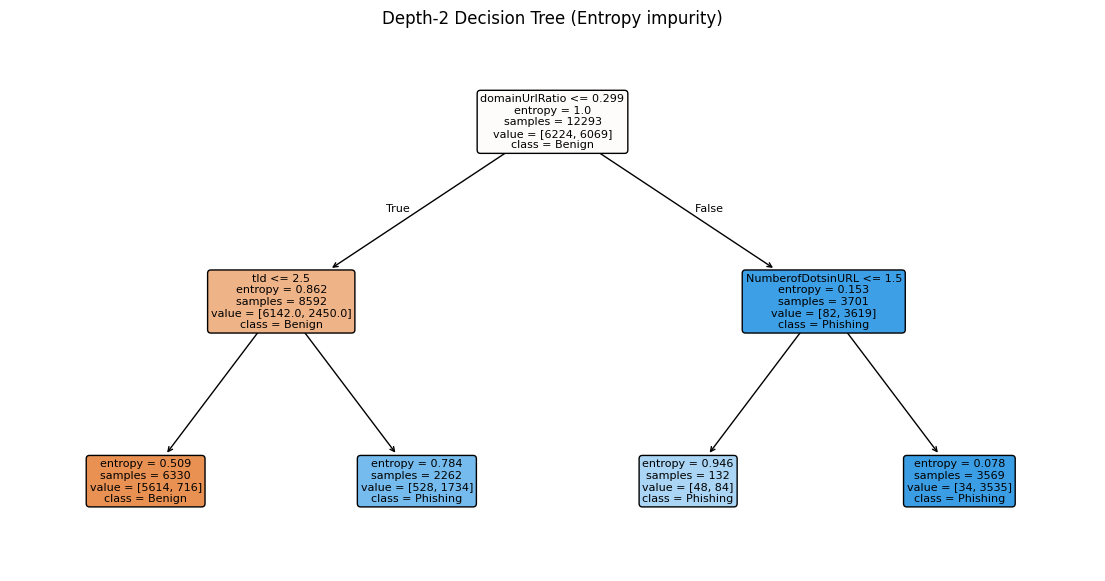

In [ ]:
plt.figure(figsize=(14, 7))
plot_tree(
    best_tree,
    feature_names=X.columns,
    class_names=["Benign", "Phishing"],
    filled=True,
    rounded=True,
    fontsize=8,
    )
plt.title("Depth-2 Decision Tree (Entropy impurity)")
plt.show()

Depth	Criterion	Accuracy	F1	Notes

1	Gini / Entropy	0.80 / 0.79	0.77 / 0.73
One-split “stumps” miss a lot of phishing (recall = 0.60).

2	Gini / Entropy	0.894 / 0.895	0.891 / 0.892
Biggest single jump (+0.13 F1 over depth 1).
Entropy edges out Gini by a hair.

3	Gini / Entropy	0.893 / 0.900	0.882 / 0.896	Small improvement; Entropy still slightly ahead.

4	Gini / Entropy	0.931 / 0.932	0.928 / 0.927	Plateau begins; both metrics level off.

5	Gini / Entropy	0.954 / 0.943	0.952 / 0.940	Gini pulls ahead when the tree gets deeper.

6	Gini / Entropy	0.958 / 0.948	0.956 / 0.945	Overall best raw scores, but the tree is large and opaque.

Key points:

Depth dominates performance: depth 1 to 2 gives the largest gain; later depths give diminishing returns.

Gini vs Entropy: Entropy is marginally better for shallow trees (depth 2 to 4); Gini wins once the tree grows deep (5 to 6). Differences are < 1 ppt.

Interpretability trade-off:

Depth-2 tree (F1 = 0.892) uses just three rules — easy to explain and deploy.

Depth-6 tree (F1 = 0.956) is more accurate but has hundreds of leaves

Performance jumps ~10 percentage points when the tree grows from depth 1 to 2, but gains get incrementally smaller after depth 4.

Gini inches ahead at depths 5 to 6. Entropy is fractionally better at shallow depths. The choice really matters only when the tree is tiny.



Model performance implied by the leaves
Precision on “Phishing” leaves:

Leaf 2b delivers 99 % precision on 3 569 test samples = a very reliable rule.

t=This simple tree achieves Accuracy = 0.895, F1 = 0.892

Recall trade-off:

The model still misses ~12 % phishing in leaf 1a (short domain & common TLD) = those are sophisticated, tidy-looking malicious URLs.
